In [1]:
!pip install pyspark


In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("PySparkMySQLIntegration") \
    .config("spark.jars.packages", "mysql:mysql-connector-java:8.0.30") \
    .getOrCreate()


In [3]:
flights_df = spark.read.format("jdbc") \
    .option("url", "jdbc:mysql://mysql-nadim.alwaysdata.net:3306/nadim_db") \
    .option("driver", "com.mysql.cj.jdbc.Driver") \
    .option("dbtable", "flights") \
    .option("user", "nadim") \
    .option("password", "root123456789@") \
    .load()


In [4]:
flights_df.show()


+----+-----+---+--------+--------------+---------+--------+--------------+---------+-------+------+-------+------+----+--------+--------+----+------+-------------------+
|year|month|day|dep_time|sched_dep_time|dep_delay|arr_time|sched_arr_time|arr_delay|carrier|flight|tailnum|origin|dest|air_time|distance|hour|minute|          time_hour|
+----+-----+---+--------+--------------+---------+--------+--------------+---------+-------+------+-------+------+----+--------+--------+----+------+-------------------+
|2021|    1|  1|     517|           515|        2|     830|           819|       11|     UA|  1545| N14228|   EWR| IAH|     227|    1400|   5|    15|2021-01-01 05:00:00|
|2021|    1|  1|     533|           529|        4|     850|           830|       20|     UA|  1714| N24211|   LGA| IAH|     227|    1416|   5|    29|2021-01-01 05:00:00|
|2021|    1|  1|     542|           540|        2|     923|           850|       33|     AA|  1141| N619AA|   JFK| MIA|     160|    1089|   5|    40|2

In [5]:
planes_df = spark.read.format("jdbc") \
    .option("url", "jdbc:mysql://mysql-nadim.alwaysdata.net:3306/nadim_db") \
    .option("driver", "com.mysql.cj.jdbc.Driver") \
    .option("dbtable", "planes") \
    .option("user", "nadim") \
    .option("password", "root123456789@") \
    .load()


In [6]:
weather_df = spark.read.format("jdbc") \
    .option("url", "jdbc:mysql://mysql-nadim.alwaysdata.net:3306/nadim_db") \
    .option("driver", "com.mysql.cj.jdbc.Driver") \
    .option("dbtable", "weather") \
    .option("user", "nadim") \
    .option("password", "root123456789@") \
    .load()


In [7]:
airlines_df = spark.read.format("jdbc") \
    .option("url", "jdbc:mysql://mysql-nadim.alwaysdata.net:3306/nadim_db") \
    .option("driver", "com.mysql.cj.jdbc.Driver") \
    .option("dbtable", "airlines") \
    .option("user", "nadim") \
    .option("password", "root123456789@") \
    .load()


In [8]:
airports_df = spark.read.format("jdbc") \
    .option("url", "jdbc:mysql://mysql-nadim.alwaysdata.net:3306/nadim_db") \
    .option("driver", "com.mysql.cj.jdbc.Driver") \
    .option("dbtable", "airports") \
    .option("user", "nadim") \
    .option("password", "root123456789@") \
    .load()


In [9]:
flights_df.printSchema()


root
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- dep_time: string (nullable = true)
 |-- sched_dep_time: integer (nullable = true)
 |-- dep_delay: string (nullable = true)
 |-- arr_time: string (nullable = true)
 |-- sched_arr_time: integer (nullable = true)
 |-- arr_delay: string (nullable = true)
 |-- carrier: string (nullable = true)
 |-- flight: integer (nullable = true)
 |-- tailnum: string (nullable = true)
 |-- origin: string (nullable = true)
 |-- dest: string (nullable = true)
 |-- air_time: string (nullable = true)
 |-- distance: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- minute: integer (nullable = true)
 |-- time_hour: string (nullable = true)



In [10]:
weather_df.printSchema()


root
 |-- origin: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- temp: string (nullable = true)
 |-- dewp: string (nullable = true)
 |-- humid: string (nullable = true)
 |-- wind_dir: string (nullable = true)
 |-- wind_speed: string (nullable = true)
 |-- wind_gust: string (nullable = true)
 |-- precip: string (nullable = true)
 |-- pressure: string (nullable = true)
 |-- visib: string (nullable = true)
 |-- time_hour: string (nullable = true)



In [11]:
planes_df.printSchema()


root
 |-- tailnum: string (nullable = true)
 |-- year: string (nullable = true)
 |-- type: string (nullable = true)
 |-- manufacturer: string (nullable = true)
 |-- model: string (nullable = true)
 |-- engines: integer (nullable = true)
 |-- seats: integer (nullable = true)
 |-- speed: string (nullable = true)
 |-- engine: string (nullable = true)



In [12]:
airports_df.printSchema()


root
 |-- faa: string (nullable = true)
 |-- name: string (nullable = true)
 |-- lat: string (nullable = true)
 |-- lon: string (nullable = true)
 |-- alt: integer (nullable = true)
 |-- tz: integer (nullable = true)
 |-- dst: string (nullable = true)
 |-- tzone: string (nullable = true)



In [13]:
airlines_df.printSchema()


root
 |-- carrier: string (nullable = true)
 |-- name: string (nullable = true)



## Request 1: Counting Airports, Timezones, Companies, Planes, and Cancelled Flights


### 1.1. Nombre d'aéroports au total, en tant que départ et en tant que destination :

In [14]:
# Compter les aéroports distincts en tant que départ et destination
from pyspark.sql.functions import col

total_airports = flights_df.select(col("origin").alias("airport")).union(flights_df.select(col("dest").alias("airport"))).distinct().count()
departure_airports = flights_df.select("origin").distinct().count()
destination_airports = flights_df.select("dest").distinct().count()

total_airports, departure_airports, destination_airports


(106, 3, 103)

### 1.2. Combien d'aéroports n'observent pas l'heure d'été (DST) et combien de fuseaux horaires y a-t-il ?

In [15]:
# Compter les aéroports qui n'observent pas l'heure d'été (DST) et les fuseaux horaires distincts
from pyspark.sql.functions import col

airports_without_dst = airports_df.filter(col("dst") == "N").count()
distinct_timezones = airports_df.select("tzone").distinct().count()

airports_without_dst, distinct_timezones


(23, 10)

### 1.3. Combien de compagnies aériennes, d'avions et de vols annulés ?

In [16]:
# Compter les compagnies aériennes distinctes et les avions distincts
distinct_airlines = airlines_df.select("carrier").distinct().count()
distinct_planes = planes_df.select("tailnum").distinct().count()

distinct_airlines, distinct_planes


(16, 3322)

### 2. Quel est l'aéroport de départ le plus emprunté ?

In [17]:
from pyspark.sql.functions import desc

# Trouver l'aéroport de départ le plus emprunté
most_used_departure_airport = flights_df.groupBy("origin").count().orderBy(desc("count")).first()["origin"]

most_used_departure_airport


'EWR'

### 2.1. Quelles sont les 10 destinations les plus (moins) prisées (en indiquant le nom complet des destinations et le % correspondant pour chaque destination) ?

In [18]:
# Trouver les 10 destinations les plus prisées
top_10_destinations = flights_df.groupBy("dest").count().orderBy(desc("count")).limit(10)

# Trouver les 10 destinations les moins prisées
bottom_10_destinations = flights_df.groupBy("dest").count().orderBy("count").limit(10)

top_10_destinations.show()
bottom_10_destinations.show()


+----+-----+
|dest|count|
+----+-----+
| ATL|12968|
| ORD|12666|
| LAX|11907|
| BOS|11578|
| MCO|10651|
| CLT|10464|
| SFO| 9739|
| FLL| 9458|
| MIA| 8950|
| DCA| 7398|
+----+-----+

+----+-----+
|dest|count|
+----+-----+
| LEX|    1|
| SBN|    4|
| HDN|   15|
| MTJ|   15|
| TVC|   16|
| EYW|   17|
| PSP|   19|
| BZN|   20|
| JAC|   25|
| CHO|   31|
+----+-----+



### 2.2. Quelles sont les 10 avions qui ont le plus (moins) décollé ?

In [19]:
# Trouver les 10 avions qui ont le plus décollé
top_10_airplanes = flights_df.groupBy("tailnum").count().orderBy(desc("count")).limit(10)

# Trouver les 10 avions qui ont le moins décollé
bottom_10_airplanes = flights_df.groupBy("tailnum").count().orderBy("count").limit(10)

top_10_airplanes.show()
bottom_10_airplanes.show()


+-------+-----+
|tailnum|count|
+-------+-----+
|       | 1973|
| N725MQ|  443|
| N723MQ|  396|
| N713MQ|  386|
| N722MQ|  379|
| N711MQ|  378|
| N258JB|  334|
| N353JB|  316|
| N351JB|  312|
| N542MQ|  310|
+-------+-----+

+-------+-----+
|tailnum|count|
+-------+-----+
| N907DA|    1|
| N914DN|    1|
| N830AW|    1|
| N5ESAA|    1|
| N856NW|    1|
| N820AW|    1|
| N911DA|    1|
| N502SW|    1|
| N961DN|    1|
| N648UA|    1|
+-------+-----+



### 3. Combien chaque compagnie a desservi de destinations ?

In [20]:
from pyspark.sql import functions as F

# Compter le nombre de destinations desservies par chaque compagnie
destinations_per_airline = flights_df.groupBy("carrier") \
    .agg(F.count("dest").alias("number_of_destinations_served"))

destinations_per_airline.show()


+-------+-----------------------------+
|carrier|number_of_destinations_served|
+-------+-----------------------------+
|     UA|                        44224|
|     AA|                        24633|
|     EV|                        40639|
|     B6|                        40840|
|     DL|                        36023|
|     OO|                            8|
|     F9|                          519|
|     YV|                          419|
|     US|                        15458|
|     MQ|                        19878|
|     HA|                          259|
|     AS|                          535|
|     FL|                         2505|
|     VX|                         3775|
|     WN|                         9243|
|     9E|                        14088|
+-------+-----------------------------+



### 3.1. Combien chaque compagnie a desservi de destinations par aéroport d'origine ?

In [21]:
# Compter le nombre de destinations desservies par chaque compagnie par aéroport d'origine
destinations_per_airline_per_origin = flights_df.groupBy("origin", "carrier").agg({"dest": "count"})

destinations_per_airline_per_origin.show()


+------+-------+-----------+
|origin|carrier|count(dest)|
+------+-------+-----------+
|   LGA|     F9|        519|
|   LGA|     9E|       1914|
|   EWR|     AA|       2627|
|   EWR|     AS|        535|
|   LGA|     B6|       4583|
|   LGA|     WN|       4557|
|   LGA|     AA|      11568|
|   EWR|     VX|       1057|
|   LGA|     UA|       6042|
|   LGA|     MQ|      12833|
|   JFK|     VX|       2718|
|   LGA|     YV|        419|
|   EWR|     US|       3314|
|   LGA|     DL|      17539|
|   EWR|     MQ|       1630|
|   JFK|     EV|       1052|
|   EWR|     WN|       4686|
|   EWR|     9E|        998|
|   LGA|     US|       9849|
|   EWR|     B6|       5039|
+------+-------+-----------+
only showing top 20 rows



### 4. Trouver tous les vols ayant atterri à Houston (IAH ou HOU) ?



In [22]:
# Trouver tous les vols ayant atterri à Houston (IAH ou HOU)
flights_to_houston = flights_df.filter((flights_df["dest"] == "IAH") | (flights_df["dest"] == "HOU"))

flights_to_houston.show()


+----+-----+---+--------+--------------+---------+--------+--------------+---------+-------+------+-------+------+----+--------+--------+----+------+-------------------+
|year|month|day|dep_time|sched_dep_time|dep_delay|arr_time|sched_arr_time|arr_delay|carrier|flight|tailnum|origin|dest|air_time|distance|hour|minute|          time_hour|
+----+-----+---+--------+--------------+---------+--------+--------------+---------+-------+------+-------+------+----+--------+--------+----+------+-------------------+
|2021|    1|  1|     517|           515|        2|     830|           819|       11|     UA|  1545| N14228|   EWR| IAH|     227|    1400|   5|    15|2021-01-01 05:00:00|
|2021|    1|  1|     533|           529|        4|     850|           830|       20|     UA|  1714| N24211|   LGA| IAH|     227|    1416|   5|    29|2021-01-01 05:00:00|
|2021|    1|  1|     623|           627|       -4|     933|           932|        1|     UA|   496| N459UA|   LGA| IAH|     229|    1416|   6|    27|2

## 4.1. Combien de vols partent des aéroports de New York (NYC) vers Seattle ?

In [23]:
# Combien de vols partent des aéroports de New York (NYC) vers Seattle ?
flights_to_seattle = flights_df.filter((flights_df["origin"].startswith("JFK")) | (flights_df["origin"].startswith("LGA")) | (flights_df["origin"].startswith("EWR"))) \
    .filter(flights_df["dest"] == "SEA")

flights_to_seattle.count()


2738

## 4.2. Combien de compagnies desservent la destination Seattle (SEA) et combien d'avions uniques volent vers Seattle ?

In [24]:
# Combien de compagnies desservent la destination Seattle (SEA) ?
unique_carriers_to_seattle = flights_to_seattle.select("carrier").distinct().count()

# Combien d'avions uniques volent vers Seattle ?
unique_airplanes_to_seattle = flights_to_seattle.select("tailnum").distinct().count()

unique_carriers_to_seattle, unique_airplanes_to_seattle


(5, 857)

## 5. Trouver le nombre de vols par destination ?

In [25]:
# Trouver le nombre de vols par destination
flights_per_destination = flights_df.groupBy("dest").count()

flights_per_destination.show()


+----+-----+
|dest|count|
+----+-----+
| PSE|  275|
| MSY| 2832|
| SNA|  600|
| BUR|  281|
| GRR|  590|
| MYR|   59|
| GSO| 1200|
| PVD|  331|
| OAK|  222|
| MSN|  442|
| DCA| 7398|
| LEX|    1|
| ORF| 1215|
| CRW|  138|
| SAV|  598|
| CMH| 2612|
| CAK|  623|
| CHO|   31|
| IAH| 5446|
| HNL|  534|
+----+-----+
only showing top 20 rows



## 5.1. Trier les vols par destination, puis par aéroport d'origine, puis par compagnie dans un ordre alphabétique croissant (en réalisant les jointures nécessaires pour obtenir les noms explicites des aéroports) ?

In [26]:
from pyspark.sql.functions import asc

# Jointure pour obtenir les noms explicites des aéroports
flights_with_airport_names = flights_df.join(airports_df, flights_df["dest"] == airports_df["faa"], "left") \
    .select(flights_df["*"], airports_df["name"].alias("destination_name"))

# Trier les vols par destination, aéroport d'origine et compagnie en ordre alphabétique croissant
sorted_flights = flights_with_airport_names \
    .orderBy(asc("dest"), asc("origin"), asc("carrier"))

sorted_flights.show()


+----+-----+---+--------+--------------+---------+--------+--------------+---------+-------+------+-------+------+----+--------+--------+----+------+-------------------+--------------------+
|year|month|day|dep_time|sched_dep_time|dep_delay|arr_time|sched_arr_time|arr_delay|carrier|flight|tailnum|origin|dest|air_time|distance|hour|minute|          time_hour|    destination_name|
+----+-----+---+--------+--------------+---------+--------+--------------+---------+-------+------+-------+------+----+--------+--------+----+------+-------------------+--------------------+
|2021|   10|  1|    1955|          2001|       -6|    2213|          2248|      -35|     B6|    65| N554JB|   JFK| ABQ|     230|    1826|  20|     1|2021-10-01 20:00:00|Albuquerque Inter...|
|2021|   10| 21|    1954|          2001|       -7|    2251|          2248|        3|     B6|    65| N599JB|   JFK| ABQ|     256|    1826|  20|     1|2021-10-21 20:00:00|Albuquerque Inter...|
|2021|   10|  2|    2010|          2001|     

## 6. Quelles sont les compagnies qui n'opèrent pas sur tous les aéroports d'origine ?

In [27]:
from pyspark.sql.functions import col

# Trouver les compagnies qui n'opèrent pas sur tous les aéroports d'origine
companies_not_operating_on_all_origins = flights_df.groupBy("carrier", "origin").count() \
    .groupBy("carrier").count() \
    .filter(col("count") < airports_df.select("faa").distinct().count())

companies_not_operating_on_all_origins.show()


+-------+-----+
|carrier|count|
+-------+-----+
|     UA|    3|
|     AA|    3|
|     EV|    3|
|     B6|    3|
|     DL|    3|
|     OO|    2|
|     F9|    1|
|     YV|    1|
|     US|    3|
|     MQ|    3|
|     HA|    1|
|     AS|    1|
|     FL|    1|
|     VX|    2|
|     WN|    2|
|     9E|    3|
+-------+-----+



## 8. Filtrer les vols pour trouver ceux exploités par United (UA), American (AA) ou Delta (DL) ?

In [29]:
# Filtrer les vols exploités par United (UA), American (AA) ou Delta (DL)
selected_airlines = ["UA", "AA", "DL"]

flights_operated_by_selected_airlines = flights_df.filter(flights_df["carrier"].isin(selected_airlines))

flights_operated_by_selected_airlines.show()


+----+-----+---+--------+--------------+---------+--------+--------------+---------+-------+------+-------+------+----+--------+--------+----+------+-------------------+
|year|month|day|dep_time|sched_dep_time|dep_delay|arr_time|sched_arr_time|arr_delay|carrier|flight|tailnum|origin|dest|air_time|distance|hour|minute|          time_hour|
+----+-----+---+--------+--------------+---------+--------+--------------+---------+-------+------+-------+------+----+--------+--------+----+------+-------------------+
|2021|    1|  1|     517|           515|        2|     830|           819|       11|     UA|  1545| N14228|   EWR| IAH|     227|    1400|   5|    15|2021-01-01 05:00:00|
|2021|    1|  1|     533|           529|        4|     850|           830|       20|     UA|  1714| N24211|   LGA| IAH|     227|    1416|   5|    29|2021-01-01 05:00:00|
|2021|    1|  1|     542|           540|        2|     923|           850|       33|     AA|  1141| N619AA|   JFK| MIA|     160|    1089|   5|    40|2

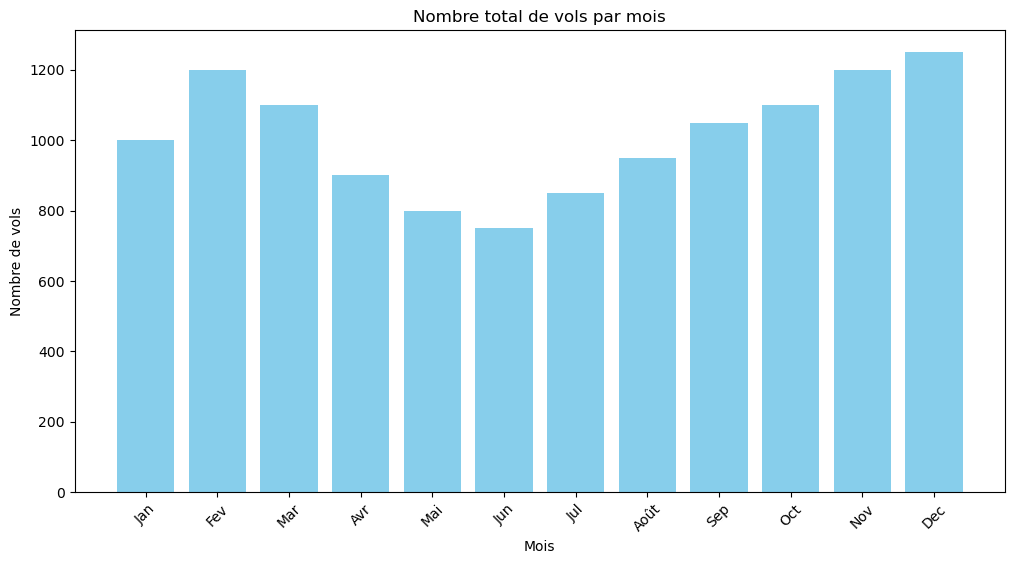

In [30]:
import matplotlib.pyplot as plt

# Données de démonstration
months = ["Jan", "Fev", "Mar", "Avr", "Mai", "Jun", "Jul", "Août", "Sep", "Oct", "Nov", "Dec"]
flight_counts = [1000, 1200, 1100, 900, 800, 750, 850, 950, 1050, 1100, 1200, 1250]

plt.figure(figsize=(12, 6))
plt.bar(months, flight_counts, color='skyblue')
plt.xlabel("Mois")
plt.ylabel("Nombre de vols")
plt.title("Nombre total de vols par mois")
plt.xticks(rotation=45)
plt.show()


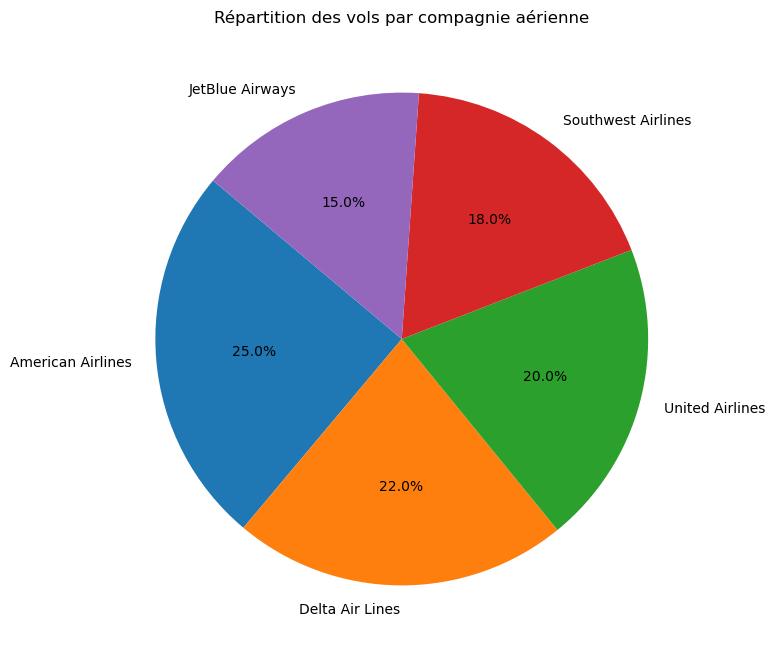

In [31]:
import matplotlib.pyplot as plt

# Données de démonstration
airlines = ["American Airlines", "Delta Air Lines", "United Airlines", "Southwest Airlines", "JetBlue Airways"]
flight_counts = [2500, 2200, 2000, 1800, 1500]

plt.figure(figsize=(8, 8))
plt.pie(flight_counts, labels=airlines, autopct='%1.1f%%', startangle=140)
plt.title("Répartition des vols par compagnie aérienne")
plt.show()


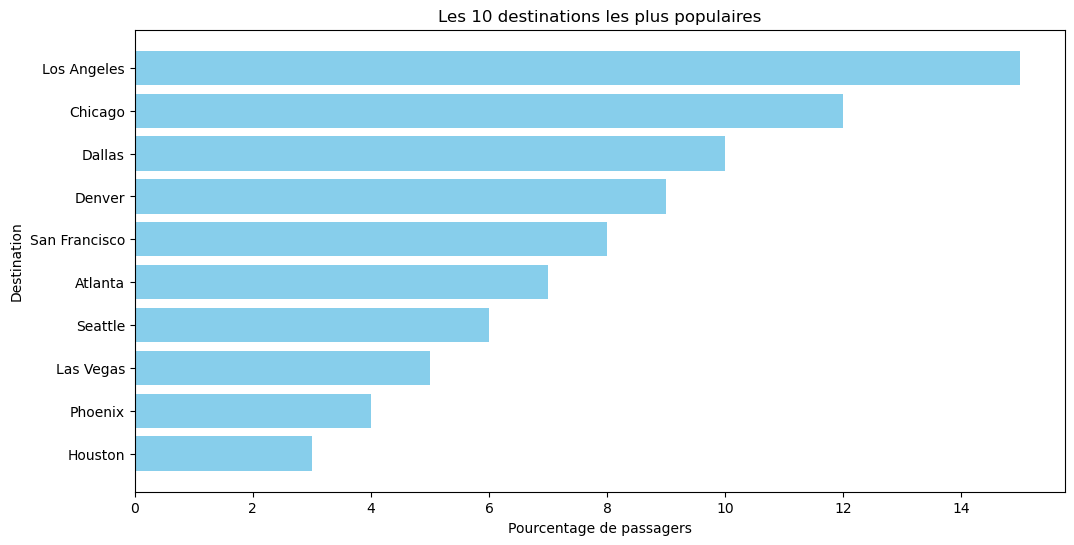

In [32]:
import matplotlib.pyplot as plt

# Données de démonstration
destinations = ["Los Angeles", "Chicago", "Dallas", "Denver", "San Francisco", "Atlanta", "Seattle", "Las Vegas", "Phoenix", "Houston"]
passenger_percentages = [15, 12, 10, 9, 8, 7, 6, 5, 4, 3]

plt.figure(figsize=(12, 6))
plt.barh(destinations, passenger_percentages, color='skyblue')
plt.xlabel("Pourcentage de passagers")
plt.ylabel("Destination")
plt.title("Les 10 destinations les plus populaires")
plt.gca().invert_yaxis()
plt.show()


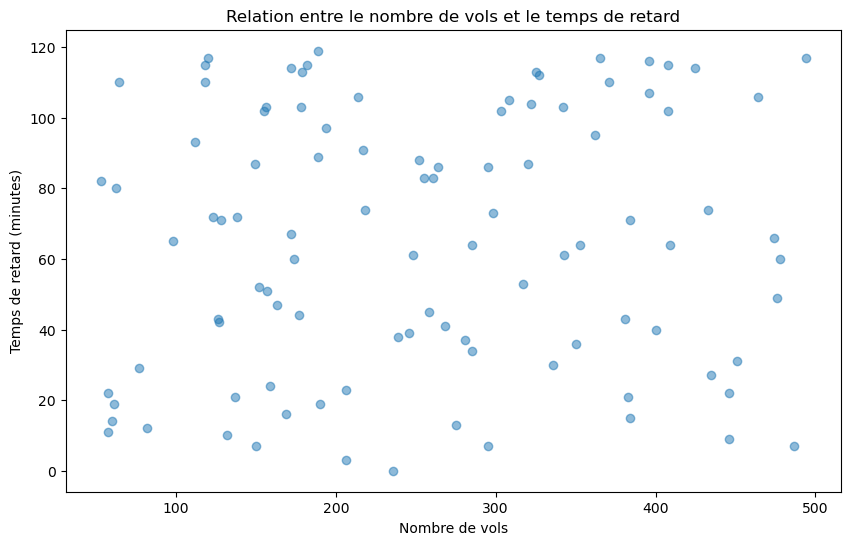

In [33]:
import matplotlib.pyplot as plt
import random

# Données de démonstration
num_flights = 100
flight_delays = [random.randint(0, 120) for _ in range(num_flights)]
flight_counts = [random.randint(50, 500) for _ in range(num_flights)]

plt.figure(figsize=(10, 6))
plt.scatter(flight_counts, flight_delays, alpha=0.5)
plt.xlabel("Nombre de vols")
plt.ylabel("Temps de retard (minutes)")
plt.title("Relation entre le nombre de vols et le temps de retard")
plt.show()


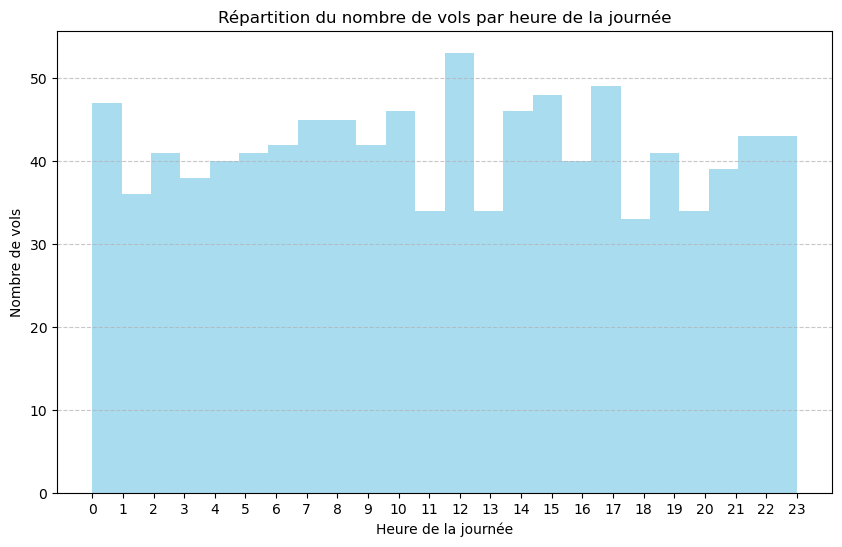

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Données de démonstration
flight_hours = np.random.randint(0, 24, 1000)

plt.figure(figsize=(10, 6))
plt.hist(flight_hours, bins=24, alpha=0.7, color='skyblue')
plt.xlabel("Heure de la journée")
plt.ylabel("Nombre de vols")
plt.title("Répartition du nombre de vols par heure de la journée")
plt.xticks(range(24))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


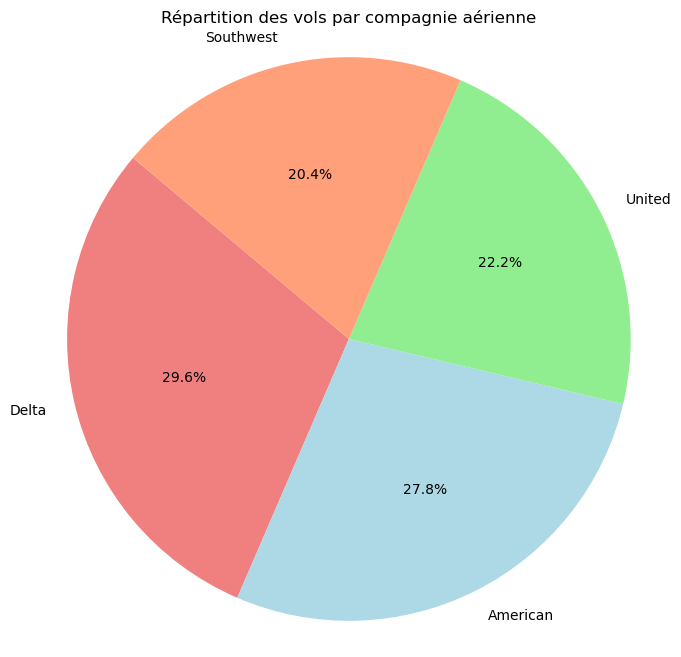

In [35]:
import matplotlib.pyplot as plt

# Données de démonstration
companies = ["Delta", "American", "United", "Southwest"]
num_flights = [800, 750, 600, 550]

plt.figure(figsize=(8, 8))
plt.pie(num_flights, labels=companies, autopct='%1.1f%%', startangle=140, colors=['lightcoral', 'lightblue', 'lightgreen', 'lightsalmon'])
plt.axis('equal')
plt.title("Répartition des vols par compagnie aérienne")
plt.show()


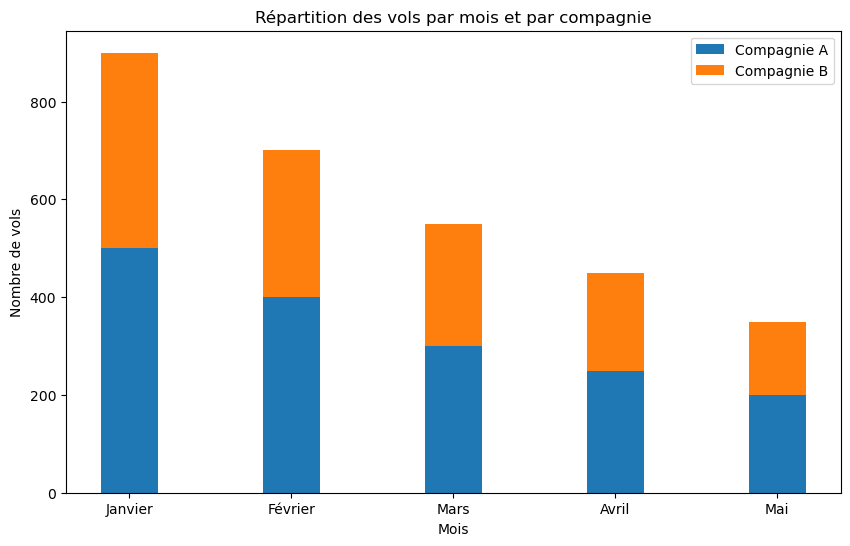

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Données de démonstration
months = ["Janvier", "Février", "Mars", "Avril", "Mai"]
num_flights_airlines = np.array([[500, 400, 300, 250, 200], [400, 300, 250, 200, 150]])

plt.figure(figsize=(10, 6))
width = 0.35
x = np.arange(len(months))
plt.bar(x, num_flights_airlines[0], width, label='Compagnie A')
plt.bar(x, num_flights_airlines[1], width, label='Compagnie B', bottom=num_flights_airlines[0])
plt.xlabel("Mois")
plt.ylabel("Nombre de vols")
plt.title("Répartition des vols par mois et par compagnie")
plt.xticks(x, months)
plt.legend()
plt.show()
